## Decision Tree Classification of Breast Cancer Survival Status

### Objective:

To classify breast cancer patients as "Alive" or "Dead" based on their characteristics using a decision tree model.

### Dataset:

This dataset comprises information on female breast cancer patients diagnosed between 2006 and 2010 with infiltrating duct and lobular carcinoma of the breast. The data was obtained from the SEER Program's November 2017 update.

**Input Variables:**

- **Age:** Age of the patient
- **Race:** Patient's race
- **Marital Status:** Marital status of the patient
- **T Stage:** Adjusted AJCC 6th T stage classification for the tumor
- **N Stage:** Adjusted AJCC 6th N stage classification for regional lymph nodes
- **6th Stage:** Breast cancer adjusted AJCC 6th stage classification
- **Differentiate:** The degree of differentiation of the tumor
- **Grade:** The grade of the tumor, indicating its aggressiveness
- **A Stage:** Regional or Distant metastasis
- **Tumor Size:** Exact size of the tumor in millimeters
- **Estrogen Status:** Status of estrogen receptor in the tumor
- **Progesterone Status:** Status of progesterone receptor in the tumor
- **Regional Node Examined:** Number of regional lymph nodes examined
- **Regional Node Positive:** Number of regional lymph nodes positive for cancer
- **Survival Months:** Number of months the patient survived after diagnosis

### Output Variable:
**Status:** Dead/Alive

## Importing libraries and Reading the Dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Breast_Cancer.csv')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Model Implementation

### Algorithm:
- Start with all examples at the root node
- Calculate gini impurity for splitting on all possible features and select the one with the lowest possible value
- Split the data according to the selected feature
- Repeat recursively until stopping criteria met.

### Gini Impurity
It is calculated for any feature as follows:
$$Gini\space Impurity\space (G) = 1 - \sum\limits_{}^{} p_{i}^2$$

In [9]:
class Node:
    def __init__(self, data):
        self.data = data
        self.children = {}
        
class DecisionTree:
    def __init__(self):
        self.root = Node(None)
        self.height = -1

    def get_splits(self, data, column_index, col_name):
        continuous_columns = ['Age', 'Tumor Size', 'Reginol Node Positive', 
                              'Regional Node Examined', 'Survival Months']
        
        if col_name not in continuous_columns:
            return []
        
        x = data[:, [column_index, -1]]
        sorted_x = x[x[:, 0].argsort()]
        potential_splits = []

        for i in range(len(sorted_x) - 1):
            curr_val = sorted_x[i][0]
            next_val = sorted_x[i + 1][0]

            if curr_val != next_val:
                mid = (curr_val + next_val) / 2
                potential_splits.append(mid)

        return potential_splits

    def gini_impurity(self, data):
        y = data[:, -1]
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        gini = 1 - np.sum(np.square(probabilities))
        return gini

    def majority_class(self, data):
        y = data.iloc[:, -1]
        cls, count = np.unique(y, return_counts=True)
        return cls[np.argmax(count)]

    def classify(self, data):
        classification = self.majority_class(data)
        gini = self.gini_impurity(data.values)
        
        d = {"ID": "Leaf", "Classification": classification, "Gini Impurity": gini, "Samples": data.shape[0]}
        leaf = Node(d)
        
        return leaf

    def build_tree(self, data, max_depth, attributes, height):
        if len(np.unique(data.iloc[:, -1])) == 1:
            leaf = self.classify(data)
            return leaf

        if height >= max_depth or len(attributes) == 0:
            leaf = self.classify(data)
            return leaf

        best = {"ID": "", "best_attribute": "", "best_split": None, "best_gini": 2}

        for attr in attributes:
            col = data.columns.get_loc(attr)
            pot_splits = self.get_splits(data.values, col, attr)

            if pot_splits:
                for val in pot_splits:
                    left_data = data[data[attr] <= val]
                    right_data = data[data[attr] > val]
                    gini = (len(left_data) * self.gini_impurity(left_data.values) +
                            len(right_data) * self.gini_impurity(right_data.values)) / len(data)

                    if gini < best["best_gini"]:
                        best.update({"ID": col, "best_attribute": attr, "best_split": val, "best_gini": gini})
            else:
                unique_values = np.unique(data.iloc[:, col])
                gini_total = 0

                for val in unique_values:
                    subset_data = data[data[attr] == val]
                    gini_val = self.gini_impurity(subset_data.values)
                    gini_total += (len(subset_data) / len(data)) * gini_val

                if gini_total < best["best_gini"]:
                    best.update({"ID": col, "best_attribute": attr, "best_split": unique_values, "best_gini": gini_total})

        if len(best["best_attribute"]) == 0:
            return self.classify(data)

        _, sample = np.unique(data["Status"], return_counts=True)
        node_data = {"ID": best["best_attribute"], "Gini Impurity": best["best_gini"], 
                     "Samples": data.shape[0], "Best_Split": best["best_split"], "Values": sample}
        node = Node(node_data)

        # print("Current height: ", height)

        if best["best_attribute"] in ['Age', 'Tumor Size', 'Reginol Node Positive', 'Regional Node Examined', 'Survival Months']:
            node.children["left"] = self.build_tree(data[data[best["best_attribute"]] <= best["best_split"]], max_depth, attributes, height + 1)
            node.children["right"] = self.build_tree(data[data[best["best_attribute"]] > best["best_split"]], max_depth, attributes, height + 1)
        else:
            node.children = {}
            for val in best["best_split"]:
                subset_data = data[data[best["best_attribute"]] == val]
                node.children[val] = self.build_tree(subset_data, max_depth, attributes, height + 1)

        return node

    def fit_to_data(self, data, max_depth):
        attributes = data.columns.tolist()[:-1]
        self.attributes = np.array(attributes)
        self.root = self.build_tree(data, max_depth, attributes, 0)

    def predict_for_data_point(self, data):
        node = self.root
        while "Classification" not in node.data.keys():
            d = node.data
            if d["ID"] in ['Age', 'Tumor Size', 'Reginol Node Positive', 'Regional Node Examined', 'Survival Months']:
                if data[np.argwhere(self.attributes == d["ID"]).squeeze()] <= d["Best_Split"]:
                    node = node.children["left"]
                else:
                    node = node.children["right"]
            else:
                val = data[np.argwhere(self.attributes == d["ID"]).squeeze()]
                node = node.children.get(val, None)
                if not node:
                    return -1

        # print(node.data["Classification"])
        return node.data["Classification"]

    def predict(self, X):
        return np.array([self.predict_for_data_point(row) for row in X])


## Fitting the Model to Data and Testing:
Here, the following have been done for epochs from 1 to 20:
- Dataset shuffled and split into training dataset and test dataset
- Each epoch has been assigned as the max depth of the tree, and the model fits according to the train_df
- Accuracy is calculated and printed for each iteration. It is also stored in a list to use for plotting the graph.

In [12]:
model = DecisionTree()
np.random.seed(88) # seed is the last two digits of my roll no

epochs = list(range(1, 21))
accuracies = []
losses = []

def validation_loss(y_true, y_pred):
    total_samples = len(y_true)
    unique_classes, pred_class_counts = np.unique(y_pred, return_counts=True)
    loss = 1.0 - sum((count / total_samples) ** 2 for count in pred_class_counts)
    
    return loss

for epoch in epochs:
    shuffled_df = df.sample(frac=1, random_state=47).reset_index(drop=True)

    train_size = int(0.8 * len(shuffled_df))

    train_df = shuffled_df[:train_size]
    test_df = shuffled_df[train_size:]

    max_depth = epoch
    model.fit_to_data(train_df, max_depth)

    X_test = test_df.values[:,:-1]
    Y_test = test_df.values[:,-1]

    Y_pred = model.predict(X_test)
    accuracy = (sum(Y_test[i] == Y_pred[i] for i in range(len(Y_test))) / float(len(Y_test))) * 100
    accuracies.append(accuracy)

    loss = validation_loss(Y_test, Y_pred)
    losses.append(loss)
    
    print(f"For iteration {epoch}, Accuracy is: {accuracy}, Validation Loss is: {loss} ")

For iteration 1, Accuracy is: 89.44099378881988, Validation Loss is: 0.1750117665213533 
For iteration 2, Accuracy is: 89.44099378881988, Validation Loss is: 0.1750117665213533 
For iteration 3, Accuracy is: 90.55900621118013, Validation Loss is: 0.13584043825469694 
For iteration 4, Accuracy is: 90.6832298136646, Validation Loss is: 0.14636472358319508 
For iteration 5, Accuracy is: 89.56521739130436, Validation Loss is: 0.1484510628447977 
For iteration 6, Accuracy is: 88.19875776397515, Validation Loss is: 0.16310173218625823 
For iteration 7, Accuracy is: 87.70186335403727, Validation Loss is: 0.19331352957061843 
For iteration 8, Accuracy is: 87.82608695652175, Validation Loss is: 0.2030045137147487 
For iteration 9, Accuracy is: 85.59006211180125, Validation Loss is: 0.24381158134331238 
For iteration 10, Accuracy is: 85.46583850931677, Validation Loss is: 0.2491447089232668 
For iteration 11, Accuracy is: 85.46583850931677, Validation Loss is: 0.2547772076694571 
For iteration 1

## Plotting Validation Accuracy vs Epochs

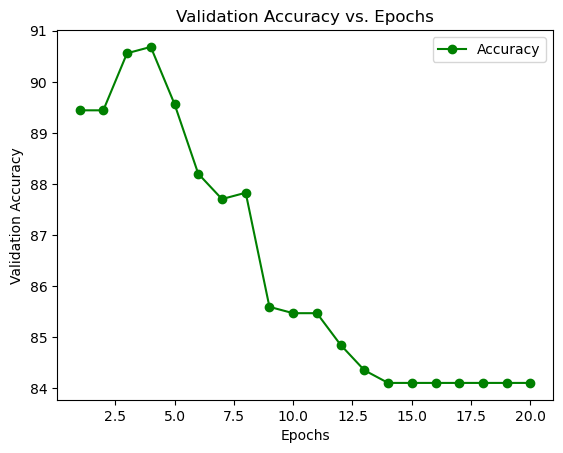

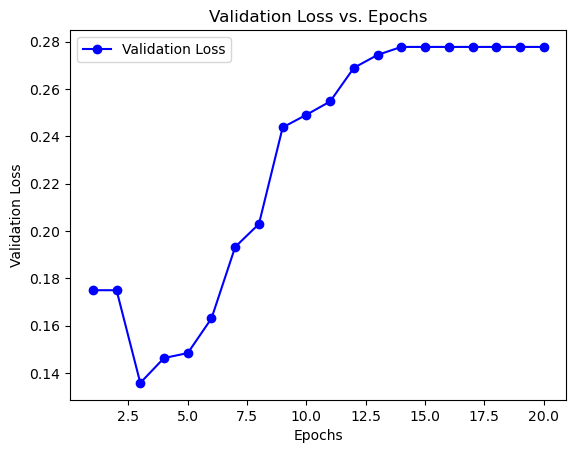

In [14]:
plt.plot(epochs, accuracies, marker = 'o', color = 'g', label = 'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.show()

plt.plot(epochs, losses, marker = 'o', color = 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epochs')
plt.legend()
plt.show()

## Conclusion
As the height of the tree increases, the model tries to overfit the training dataset, and as a consequence, performs poorer on the test dataset. Thus, the accuracy first increases, reaching an optimum (this height balances the bias and variance the best) and then falls.